In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pylab as py

from matplotlib import animation, rc
from IPython.display import HTML

Данная задача является частным случаем так называемой задачи трех тел, состоящей в определении относительного движения трёх тел (материальных точек), взаимодействующих по закону тяготения Ньютона. Для начала определим необходимые и желаемые параметры:

In [2]:
# Parameters

yr = 365 * 24 * 3600 # 1 год в секундах

t0 = 0  #начало
tf = 3 * yr   #сколько лет модели хотим

points =  3 * 365    #3 года 365 дней, хотим по точке в день
points = int(points) #точек в год 365
t = np.linspace(t0, tf, points)   #time array под наши желания
step = t[1] - t[0] #шаг времени

#для краткости
N = points
h = step 

#Constants:

G = 6.667e-11  # гравитационная постоянная, м^3 кг^-1 с^-2
Sm = 1.9885e30  # масса Солнца, кг
Em = 5.97e24  # масса Земли, кг
Mm = 7.348e22  # масса Луны, кг 

Мы будем решать задачу, учитиывая только равитационные силы


\begin{equation}
F=G\frac{{m_1}{m_2}}{{r^2}}
\end{equation}

Движение планет вокруг Солнца почти целиком определяется силами их притяжения к Солнцу. Из-за того, что массы планет малы по сравнению с массой Солнца, действующие между планетами силы тяготения приводят лишь к сравнительно небольшим отклонениям от законов Кеплера. 


Сложная петлеобразная или волнообразная траектория спутника в системе отсчета, связанной со звездой, объясняется сложением двух движений: движения по большой окружности (или эллипсу) вместе с планетой вокруг звезды и обращения вокруг звезды по малой окружности (или малому эллипсу).


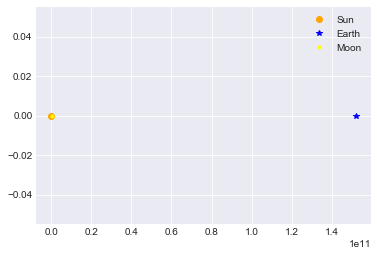

In [3]:
%matplotlib inline

re = np.zeros([N,2])         # position vector of Earth
ve = np.zeros([N,2])         # velocity vector of Earth
rm = np.zeros([N,2])        # position vector of moon
vm = np.zeros([N,2])        # velocity vector of moon
rt = np.zeros([N,2])

e0 = [ 15183e7, 0]      # initial position of earth 
m0 = [ (3844e5) , 0]           # initial position of Moon 
s0 = [0,0]

# Проверим положения тел

plt.figure()
plt.style.use('seaborn-darkgrid')


plt.plot(s0[0], s0[1], 'o', color = 'orange', label = 'Sun')
plt.plot(e0[0], e0[1], '*', color = 'blue', label = 'Earth')
plt.plot(m0[0], m0[1], '.', color = 'yellow', label = 'Moon')

plt.legend()

Скорости вращениия тел по орбите 


\begin{equation}
V=\sqrt\frac{{G}{M}}{{r}}
\end{equation}


(первая космическая)

Рассматривая Луну, мы будем рассматривать ее движение относительно  Земли, а не относительно Солнца. Система отсчета, связанная с планетой, не является инерциальной: она вместе с планетой подвержена ускорению, направленному к Солнцу. Когда спутник находится близко к планете, солнечное притяжение сообщает ему почти такое же ускорение, как и самой планете. Поэтому вмешательство Солнца в движение спутника относительно планеты оказывается незначительным: в главных чертах это движение описывается законами Кеплера. 

In [4]:
ve0 = np.sqrt(Sm * G / e0[0]) 
vm0 = np.sqrt(Em * G / m0[0]) 

vei = [0, ve0] # начальная скорость Земли
vmi = [0, vm0] #начальная скорость Луны

t[0] = t0
re[0, :] = e0
ve[0, :] = vei
rm[0, :] = m0
vm[0, :] = vmi


Кеплерово движение спутника относительно Земли возмущается не самим по себе солнечным тяготением, а лишь его неоднородностью.На протяжении околоземной орбиты спутника неоднородность поля тяготения Солнца незначительна. Поэтому при расчете движения спутника вблизи планеты будетм в первом приближении учитывать его притяжение только планетой. 


In [5]:
def force_s_e(r):
    
    F = np.zeros(2)
    
    Ffull = G * Em * Sm / ( np.linalg.norm(r) ) ** 2
    phi = math.atan( np.abs(r[1]) / np.abs(r[0]) ) 
    F[0] = Ffull * np.cos(phi)
    F[1] = Ffull * np.sin(phi)
                      
    if r[0] > 0:
        
        F[0] = -F[0]
                      
    if r[1] > 0:
        
        F[1] = -F[1]
        
    return F

def force_e_m(r):
                      
    F = np.zeros(2)
    
    Ffull = G * Mm * Em / ( np.linalg.norm(r) )**2
    phi = math.atan( np.abs(r[1]) / np.abs(r[0] ) )
    F[0] = Ffull * np.cos(phi)
    F[1] = Ffull * np.sin(phi)
                      
    if (r[0]) > 0:
        
        F[0] = -F[0]
                    
    if (r[1]) > 0:
        
        F[1] = -F[1]
        
    return F

    
    
def dv_dt(t, r, v, body, r0, v0):
    
    
    if body == 'Earth':
        
        a = force_s_e (r) / Em
        
    if body == 'Moon':
        
        a = force_e_m (r) / Mm 
        
    return a

def dr_dt(t, r, v, body, r0, v0):
    
    return v

Для интегррования ОДУ выберем метод Рунге-Кутты 4го порядка. Важными его свойствами являются не только порядок точности, но и возможность автоматического управления длиной шага и устойчивость методов. 

In [6]:
def run_cut(t, r, v, h, body, r_init, v_init):
    
    k11 = dr_dt(t, r, v, body, r_init, v_init) 
    k21 = dv_dt(t, r, v, body, r_init, v_init)
    
    k12 = dr_dt(t + 0.5*h,r + 0.5*h*k11,v + 0.5*h*k21,body, r_init, v_init)
    k22 = dv_dt(t + 0.5*h,r + 0.5*h*k11,v + 0.5*h*k21,body, r_init, v_init)
    
    k13 = dr_dt(t + 0.5*h,r + 0.5*h*k12,v + 0.5*h*k22,body, r_init, v_init)
    k23 = dv_dt(t + 0.5*h,r + 0.5*h*k12,v + 0.5*h*k22,body, r_init, v_init)
    
    k14 = dr_dt(t + h,r + h*k13,v + h*k23,body, r_init, v_init)
    k24 = dv_dt(t + h,r + h*k13,v + h*k23,body, r_init, v_init)
    
    y0 = r + h * (k11 + 2.*k12 + 2.*k13 + k14) / 6.
    y1 = v + h * (k21 + 2.*k22 + 2.*k23 + k24) / 6.
    
    z = np.zeros([2,2])
    z = [y0, y1]
    
    return z

In [7]:
#расчет траектории


for i in range(0, N-1):
    
    [re[i+1,:],ve[i+1,:]]= run_cut(t[i],re[i,:],ve[i,:],h,'Earth', vei, e0)
    
    [rm[i+1,:],vm[i+1,:]]= run_cut(t[i],rm[i,:],vm[i,:],h,'Moon', vmi, m0)


In [8]:
#Переносм Луну на земную орбиту 

for i in range(0, N):   
    
    rm[i,:] = re[i,:] + rm[i,:]

<IPython.core.display.Javascript object>


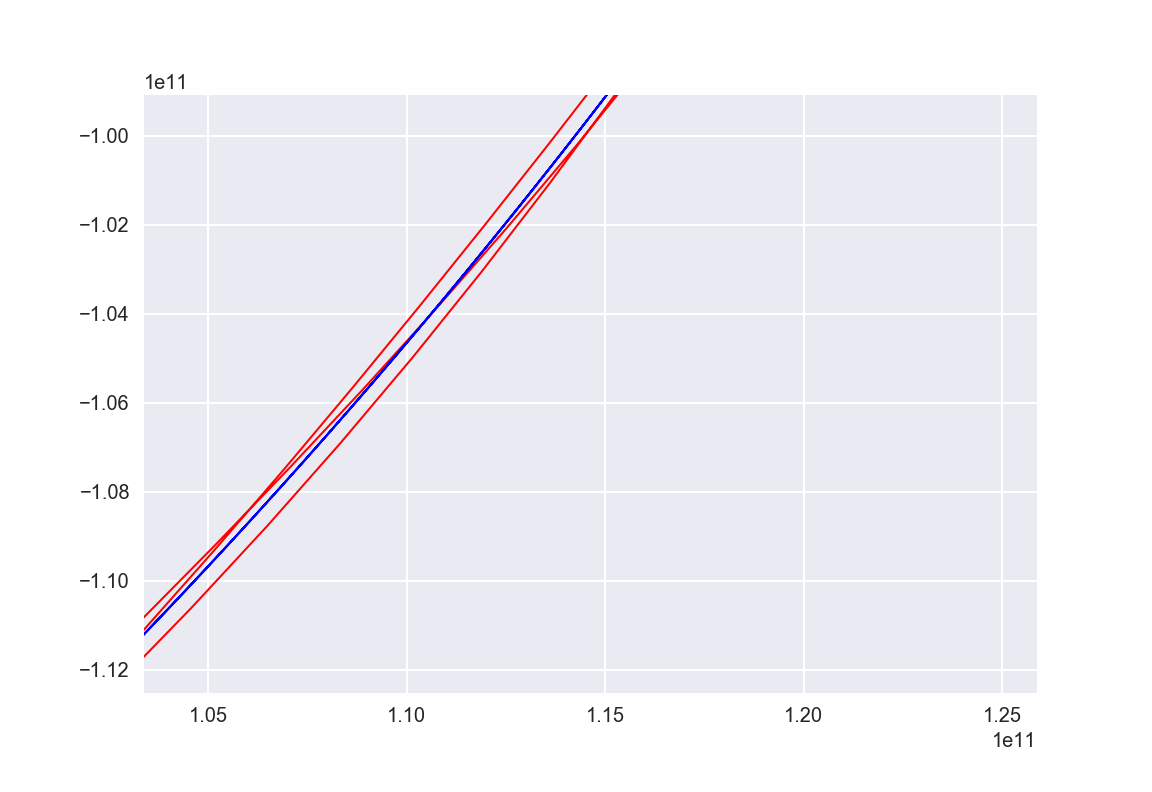

In [12]:
%matplotlib notebook

plt.style.use('seaborn')
plt.figure()
plt.plot(-5004151, 0, 'ro',linewidth = 7)
#py.plot(m0[0], m0[1],'o',linewidth = 7)
#py.plot(e0[0], e0[1],'o',linewidth = 7)
plt.plot(rm[:,0], rm[:,1],'-',linewidth = 1, color = 'red')
plt.plot(re[:,0], re[:,1],'-',linewidth = 1, color = 'blue')
plt.show()

<IPython.core.display.Javascript object>


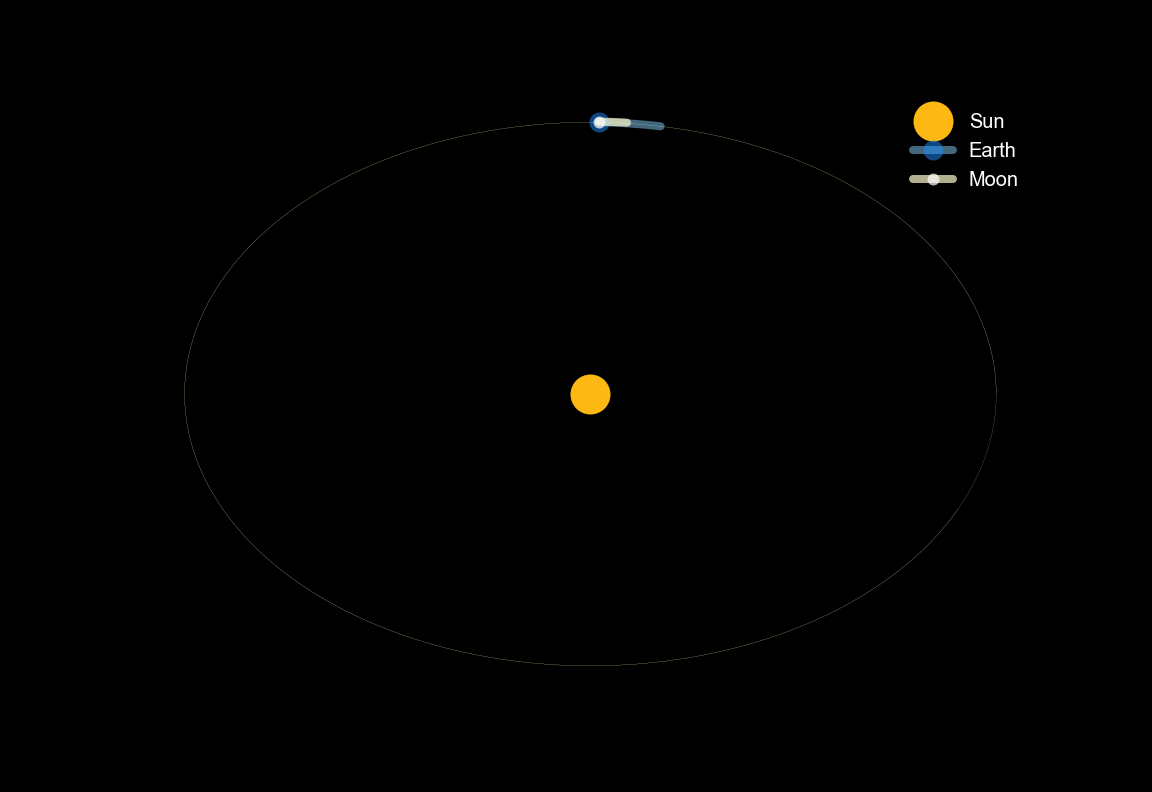

In [13]:
import matplotlib.animation as animation
%matplotlib notebook

plt.style.use('dark_background')

tt = points

fig, ax = plt.subplots()

ax.axisbg = 'white'

x = re[:,0]
y = re[:, 1]
m1 = rm[:,0]
m2 = rm[:,1]

ax.plot(-5004151,0,'o',markersize = 20, markerfacecolor = "#FDB813",markeredgecolor ="#FD7813", label = 'Sun')
l = plt.plot(x, y, '--', lw = 0.05)
ax.set_autoscale_on(True)

line1, = plt.plot([], [], 'o-',color = 'lightskyblue',markevery=10000, markersize = 10, markerfacecolor = 'dodgerblue' ,lw=4, alpha=.5, label = 'Earth')
line2, = ax.plot([], [], 'o-',color = 'lemonchiffon',markersize = 6, markerfacecolor = 'white',lw=4,markevery=10000, alpha = 0.7, label = 'Moon')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])

def animate(i):
    earth_trail = 10
    moon_trail = 5
    line1.set_data(x[i:max(1,i-earth_trail):-1], y[i:max(1,i-earth_trail):-1])
    line2.set_data(m1[i:max(1,i-moon_trail):-1], m2[i:max(1,i-moon_trail):-1])
    
    return line1, line2,

model = animation.FuncAnimation(fig, animate, frames=tt, repeat=True)

plt.show()

plt.legend(loc = 'best')

In [97]:
HTML(model.to_html5_video())